In [22]:
import os
import glob
import json
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split

In [23]:
BATCH_SIZE=32
HEIGHT=224
WIDTH=224

In [24]:
fake_files = glob.glob('../input/fakeavceleb0/FakeAVCeleb_preprocessed/DATA/TRAIN/EXTRACTED/FRAMES/*FAKE*/*/*.jpg')
real_files = glob.glob('../input/fakeavceleb0/FakeAVCeleb_preprocessed/DATA/TRAIN/EXTRACTED/FRAMES/*REAL*/*/*.jpg')
print(len(fake_files),len(real_files))

389750 63678


In [25]:
train_df = pd.DataFrame(columns=['directory','label'])

In [26]:
for i in range(30000):
    train_df=train_df.append({'directory':fake_files[i],'label':1.0},ignore_index=True)
    train_df=train_df.append({'directory':real_files[i],'label':0.0},ignore_index=True)

# for i in fake_files[:10000]:
#     train_df=train_df.append({'directory':i,'label':1.0},ignore_index=True)
# for i in real_files[:10000]:
#     train_df=train_df.append({'directory':i,'label':0.0},ignore_index=True)

In [27]:
X= train_df['directory']
y= train_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,shuffle=True)

In [28]:
del(fake_files)
del(real_files)

In [29]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(45000,) (45000,) (15000,) (15000,)


In [30]:
def load_images(files):
    images=[]
    for i in files:
        a = Image.open(i)
        a = np.asarray(a)
#         a = a/255.0
        images.append(a)
    return np.array(images)

In [31]:
def DataGen(data,label,bsize=BATCH_SIZE):
    while True:
        for i in range(len(data)):
#             rand = np.random.randint(0,len(data)-BATCH_SIZE)
            images = load_images(data[i:i+BATCH_SIZE])
            labels = label[i:i+BATCH_SIZE]
            yield np.array(images),np.array(labels)

In [32]:
train_dataset = DataGen(X_train,y_train)
valid_dataset = DataGen(X_test,y_test)

In [33]:
a,b = next(train_dataset)
c,d = next(valid_dataset)
print(a.shape,b.shape,c.shape,d.shape)

(32, 224, 224, 3) (32,) (32, 224, 224, 3) (32,)


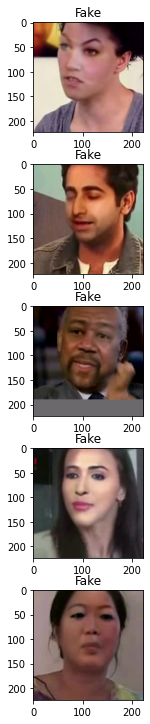

In [34]:
def sample_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        
        axs[i].imshow(image[i])
        axs[i].set_title('Real' if label[i]==0.0 else 'Fake')
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
sample_plot(a,b)

In [35]:
inputs = tf.keras.layers.Input((HEIGHT,WIDTH,3))
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.1),
#   layers.RandomWidth(factor=(0.2, 0.3), 
#                      interpolation='bilinear') ,
  layers.RandomZoom(height_factor=(0.1, 0.2), 
                    width_factor=(0.1, 0.2), 
                    fill_mode='reflect',
                    interpolation='bilinear') 
])(inputs)
    
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet',pooling='max')
base_model.trainable=True
x = base_model(data_augmentation,training=True)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5),tf.keras.metrics.AUC()])

43950080/43941136 [==============================] - 1s 0us/step


In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                24592     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 10,808,144
Trainable params: 10,720,841
Non-trainable params: 87,303
__________________________________________

In [37]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('baseline_model.hdf5', monitor='val_auc', verbose=1, save_best_only=True, mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',patience=3,verbose=1,factor=0.5,min_lr=1e-5)
TRAIN_STEPS = 100
VAL_STEPS = 25
EPOCHS = 20
history = model.fit(train_dataset, steps_per_epoch=TRAIN_STEPS,validation_data=(valid_dataset),validation_steps=VAL_STEPS,
                    batch_size=BATCH_SIZE,epochs=EPOCHS, callbacks = [checkpoint,lr_reducer])

Epoch 1/20
100/100 [==============================] - 59s 454ms/step - loss: 0.2431 - binary_accuracy: 0.9344 - auc_1: 0.9758 - val_loss: 0.3342 - val_binary_accuracy: 0.9225 - val_auc_1: 0.9670
Epoch 2/20
100/100 [==============================] - 43s 428ms/step - loss: 0.0792 - binary_accuracy: 0.9766 - auc_1: 0.9942 - val_loss: 0.2209 - val_binary_accuracy: 0.9625 - val_auc_1: 0.9804
Epoch 3/20
100/100 [==============================] - 43s 428ms/step - loss: 0.0363 - binary_accuracy: 0.9878 - auc_1: 0.9987 - val_loss: 0.1278 - val_binary_accuracy: 0.9700 - val_auc_1: 0.9876
Epoch 4/20
100/100 [==============================] - 43s 432ms/step - loss: 0.0206 - binary_accuracy: 0.9944 - auc_1: 0.9991 - val_loss: 0.0550 - val_binary_accuracy: 0.9712 - val_auc_1: 0.9996
Epoch 5/20
100/100 [==============================] - 42s 423ms/step - loss: 0.0158 - binary_accuracy: 0.9947 - auc_1: 0.9995 - val_loss: 0.0529 - val_binary_accuracy: 0.9787 - val_auc_1: 0.9999
Epoch 6/20
100/100 [=====

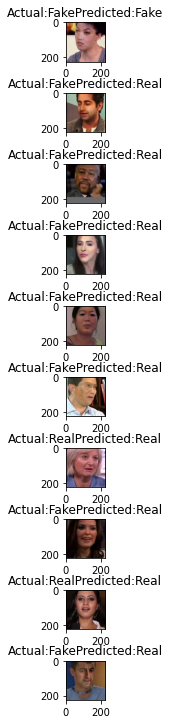

In [38]:
def test_plot(image,label):
    fig, axs = plt.subplots(10, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(10):
        y_pred = model.predict(np.reshape(image[i],(1,HEIGHT,WIDTH,3)))
        y_pred = 1.0 if y_pred>0.5 else 0.0
        y_pred_l= 'Real' if y_pred==0.0 else 'Fake'
        y_true_l = 'Real' if label[i]==0.0 else 'Fake'
        axs[i].imshow(image[i])
        axs[i].set_title('Actual:'+y_true_l+'Predicted:'+y_pred_l)
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
test_plot(a,b)

In [39]:
model.save('baseline.hdf5')